In [39]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from typing import Tuple, List

In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size = self.Nx) * np.sqrt(dt)
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt
        return t_data, x_data

Task 1. Use the stochastic integral Ito, $N=1000$ to simulate and plot a path with $X_0 = 10$ of

the Ornstein-Uhlenbeck process, $\mathbb{\theta} = (-5.0, 0.0, 3.5)$;

the Cox-Ingersoll-Ross process, $\mathbb{\theta} = (2.00, 0.20, 0.15)$;

the Black-Scholes-Merton process, $\mathbb{\theta} = (1.0, 0.2)$.
   

In [3]:
class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]

    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)


class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)


class BlackScholesMertonProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x

    def sampler_init_state(self):
        return np.ones(self.Nx)

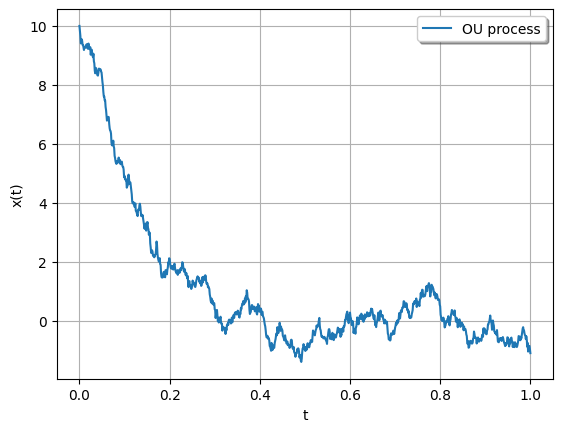

In [4]:
T = 1
Nx = 1
Nt = 1000

init_state = 10 * np.ones(Nx)

theta = 5
mu = 0
sigma = 3.5
params = [theta, mu, sigma]

OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)
t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'OU process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

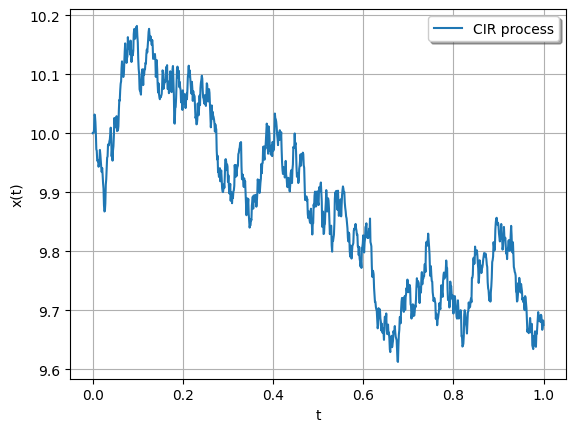

In [5]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'CIR process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

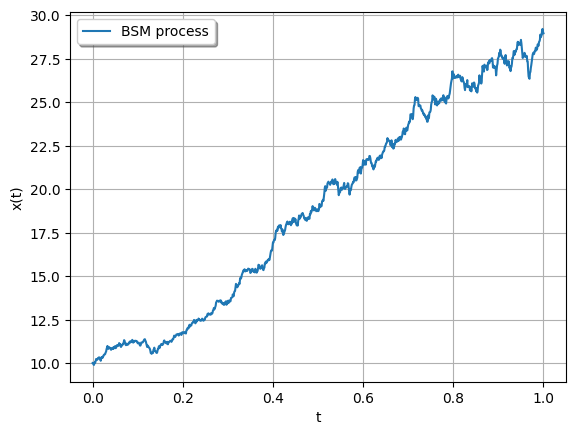

In [6]:
theta1 = 1.0
theta2 = 0.2
params = [theta1, theta2]

BSMProcess = BlackScholesMertonProcess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'BSM process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 2. Compute a confidence interval of the CIR process from the previous task. Plot the paths and a confidence interval.

In [7]:
def zeta(sigma, theta, t, s):
    return sigma**2 / (4 * theta) * (1 - np.exp(-theta * (t - s)))

def CIRbounds(alpha_interval, params, t, s, xs):
    theta1, theta2, theta3 = params[0], params[1], params[2]
    theta = theta2
    beta = theta1 / theta2
    sigma = theta3

    k = 4  / sigma**2 * theta * beta
    lambd = 4 * theta / sigma**2  * np.exp(-theta * (t - s)) / (1 - np.exp(-theta * (t - s))) * xs
    ksi = norm.ppf(1 - alpha_interval / 2)

    b1 = zeta(sigma, theta, t, s) * (k + lambd - ksi * np.sqrt(2 * (k + 2 * lambd)))
    b2 = zeta(sigma, theta, t, s) * (k + lambd + ksi * np.sqrt(2 * (k + 2 * lambd)))
    return [b1, b2]


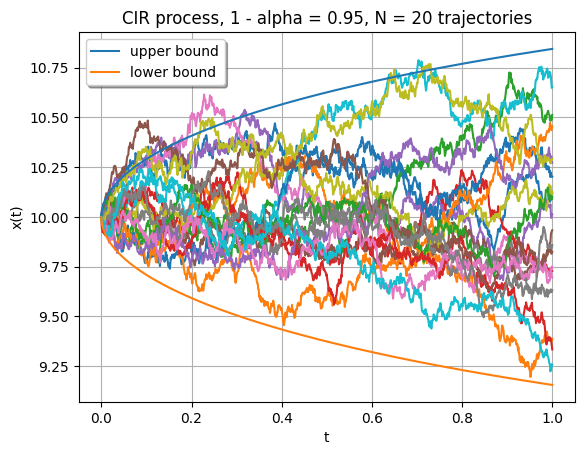

In [10]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

Nx = 20

x0 = 10
init_state = x0 * np.ones(Nx)
alpha_interval = 0.05

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
for k in range(0, Nx):
    plt.plot(t_data, x_data[:,k])

low_bound_data = np.zeros_like(t_data)
up_bound_data = np.zeros_like(t_data)

for i in range(1, len(t_data)):
    bounds = CIRbounds(alpha_interval, params, t_data[i], 0, x0)
    low_bound_data[i] = bounds[0]
    up_bound_data[i] = bounds[1]
low_bound_data[0] = x0
up_bound_data[0] = x0
plt.plot(t_data, up_bound_data, label = f"upper bound")
plt.plot(t_data, low_bound_data, label = f"lower bound")

plt.title(f"CIR process, 1 - alpha = {1-alpha_interval}, N = {Nx} trajectories")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 3. For the Ornstein-Uhlenbeck process
$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t, \quad \theta = 1, \quad \mu = 1.2, \quad \sigma = 0.3
$$
generate three paths: $X_0 = 0.0, 2.0, \mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right)$ and plot in graph.


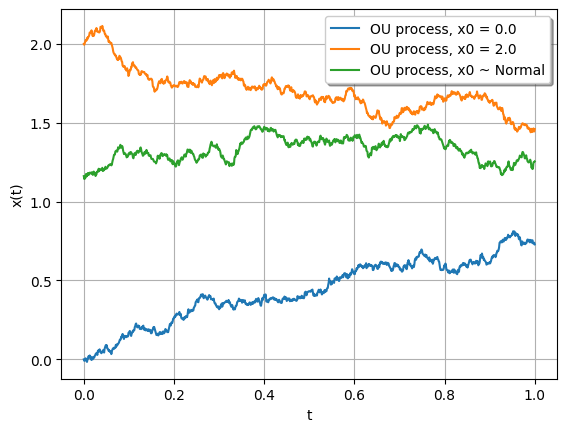

In [9]:
T = 1
Nx = 1
Nt = 1000

theta = 1
mu = 1.2
sigma = 0.3
params = [theta, mu, sigma]

x0 = 0.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')

x0 = 2.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')


init_state = np.random.normal(mu, sigma**2/(2 * theta), size = Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 ~ Normal')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Define a path with the stationary distribution from the graph and prove mathematically.

the Ornstein-Uhlenbeck process has a mean = $\mu$ and varience = $\frac{\sigma}{2\mu}$

having an explicit solution 

$$X_t = x_0 + \mu(1 - e^{-\theta t}) + \sigma \int_{0}^{t}e^{-\theta(t-u)dW_u}$$

In [ ]:
# your code for prove


Task 4.  Design a process that stays in the interval $[0, 1]$ and mean-reverts
around $1/2$, generate a path and plot it in graph. Prove your solution.


Hint
$$
\mu(x) = \theta (1/2 - x), \quad \sigma(x) = \sigma \cdot x (1-x).
$$

That is
$$
dx = \theta (1/2 - x )dt + \sigma \cdot x (1-x) dW.
$$
Note: diffusion goes to zero at boundaries $\sigma(0) = \sigma(1) = 0$ and
mean-reverts  $⇒$ always stay in $[0, 1]$.

solution:

The process has drift μ(x)=θ(1/2−x), which ensures that the process reverts toward 1/2, 


and the diffusion term σ(x)=σ⋅x(1−x), which goes to zero at the boundaries x=0 and x=1, ensuring that the process remains within [0,1]

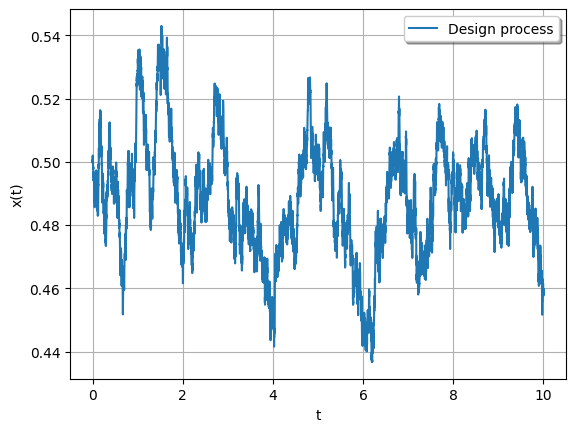

In [16]:
class DesignProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: self.params[0] * (1/2 - x)
        self.sigmaxt = lambda x: self.params[1] * x * (1 - x)

    def sampler_init_state(self):
        return 0.5 * np.ones(self.Nx)
    

# Parameters
theta = 3.0  # Mean-reversion speed
sigma = 0.2  # Volatility
x0 = 0.5     # Initial condition (start at 1/2)
Nx = 1
Nt = 10000
T = 10.0 

params = [theta, sigma]

init_state = x0 * np.ones(Nx)

DesProcess = DesignProcess(params, T, Nx, Nt, init_state)
t_data, x_data = DesProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'Design process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()


Task 5. Using the class template from Task 1, create classes and plot graphs for the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.





# the Modified CIR SDE:

$$dX_t = -\theta_1 X_tdt + \theta_2\sqrt{1 + X_t^2}dW_t$$

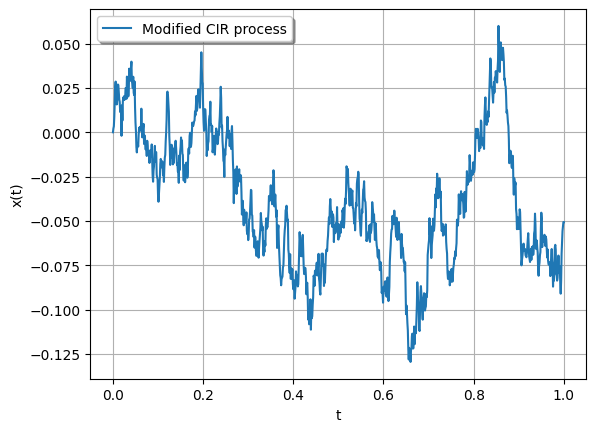

In [24]:
class ModifiedCIRProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        try:
            assert params[0] + params[1]**2 > 0
            
            super().__init__(params, T, Nx, Nt, init_state)

            # params = [theta1, theta2]
            self.bxt = lambda x: - self.params[0] * x
            self.sigmaxt = lambda x: self.params[1] * np.sqrt(1 + x**2)
        except AssertionError:
            print(f'theta1 and theta2 must fit the condition: theta1 + theta2^2 > 0, but {params[0] + params[1]**2} where given')

    def sampler_init_state(self):
        return -np.ones(self.Nx)
    
# Parameters
theta1 = 3.0  
theta2 = 0.2
x0 = 0 
Nx = 1
Nt = 1000
T = 1.0 

params = [theta1, theta2]

init_state = x0 * np.ones(Nx)

ModifiedCIR = ModifiedCIRProcess(params, T, Nx, Nt, init_state)
t_data, x_data = ModifiedCIR.EulerSolution()
plt.plot(t_data, x_data, label = 'Modified CIR process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

# the Chan-Karolyi-Longstaff-Sanders family of models

solves the following SDE:

$$dX_t = (\theta_1 + \theta_2 X_t)dt + \theta_3 X_t^{\theta_4} dW_t$$

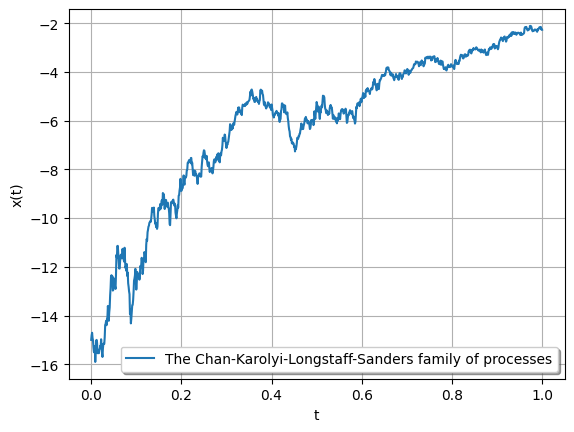

In [31]:
class CKLSProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        try:
            assert params[0] > 0 and params[1] > 0 and params[2] > 0 and params[3] > 1/2

            super().__init__(params, T, Nx, Nt, init_state)

            # params = [theta1, theta2, theta3, theta4]
            self.bxt = lambda x: self.params[0] + self.params[1] * x
            self.sigmaxt = lambda x: self.params[2] * x**self.params[3]
        except AssertionError:
            print(f'params do not fit the condition: theta1 > 0, theta2 > 0, theta3 > 0 and theta4 > 1/2, but {params} where given')

    def sampler_init_state(self):
        return -self.params[0] / self.params[1] * np.ones(self.Nx)
    
# Parameters
theta1 = 3.0  
theta2 = 0.2
theta3 = 0.7
theta4 = 1
x0 = 0 
Nx = 1
Nt = 1000
T = 1.0 

params = [theta1, theta2, theta3, theta4]

CKLR = CKLSProcess(params, T, Nx, Nt)
t_data, x_data = CKLR.EulerSolution()
plt.plot(t_data, x_data, label = 'The Chan-Karolyi-Longstaff-Sanders family of processes')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

# non linear mean reversion Ait-Sahalia model

the model satisfies the nonlinear SDE:

$$X_t = (\alpha_1 X_t^{-1} + \alpha_0 + \alpha_2 X_t + \alpha_3 X_t^2)dt + \beta_1 X_t^{\rho}dW_t$$

and the second form:

$$X_t = (\alpha_1 X_t^{-1} + \alpha_0 + \alpha_2 X_t + \alpha_3 X_t^2)dt + \sqrt{\beta_0 + \beta_1X_t + \beta_2X_t^{\rho}}dW_t$$


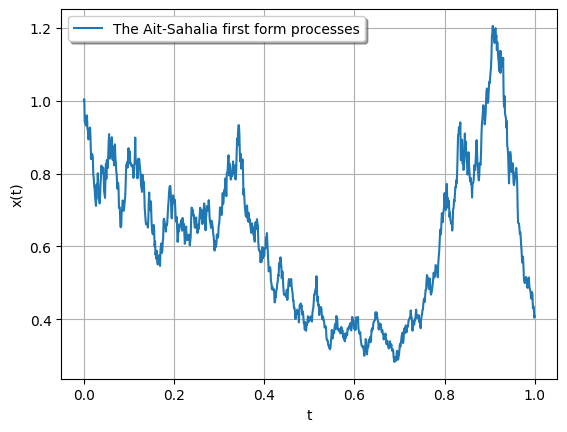

In [32]:
class AitSahaliaFirstProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):

        super().__init__(params, T, Nx, Nt, init_state)

        # params = [alpha0, alpha1, alpha2,  alpha3, beta1, rho]
        self.bxt = lambda x: self.params[0] + self.params[1] / x + self.params[2] * x + self.params[3] * x ** 2
        self.sigmaxt = lambda x: self.params[4] * x ** self.params[5]

    def sampler_init_state(self):
        return np.ones(self.Nx)
    
# Parameters
alpha0 = 1
alpha1 = 0.2
alpha2 = 0.5
alpha3 = 0.3
beta1 = 1.
rho = 1.

x0 = 0 
Nx = 1
Nt = 1000
T = 1.0 

params = [alpha0, alpha1, alpha2, alpha3, beta1, rho]

AitSahaliaFirst = AitSahaliaFirstProcess(params, T, Nx, Nt)
t_data, x_data = AitSahaliaFirst.EulerSolution()
plt.plot(t_data, x_data, label = 'The Ait-Sahalia first form processes')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

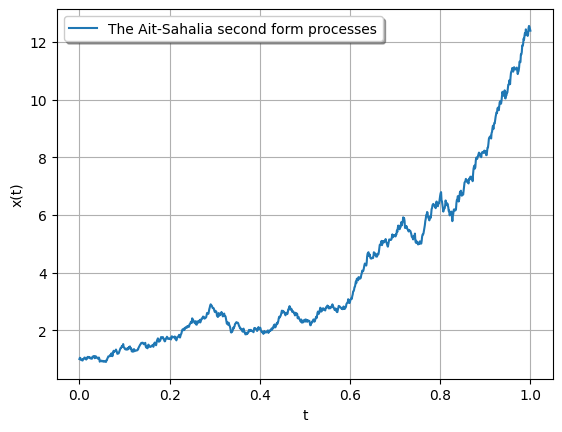

In [35]:
class AitSahaliaSecondProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):

        super().__init__(params, T, Nx, Nt, init_state)

        # params = [alpha0, alpha1, alpha2,  alpha3, beta0, beta1, beta2, rho]
        self.bxt = lambda x: self.params[0] + self.params[1] / x + self.params[2] * x + self.params[3] * x ** 2
        self.sigmaxt = lambda x: np.sqrt(self.params[4] + self.params[5] * x + self.params[6] * x ** self.params[7])

    def sampler_init_state(self):
        return np.ones(self.Nx)
    
# Parameters
alpha0 = 1
alpha1 = 0.2
alpha2 = 0.5
alpha3 = 0.3
beta0 = 0.1
beta1 = 1.
beta2 = 0.1
rho = 1.

x0 = 0 
Nx = 1
Nt = 1000
T = 1.0 

params = [alpha0, alpha1, alpha2, alpha3, beta0, beta1, beta2, rho]

AitSahaliaSecond = AitSahaliaSecondProcess(params, T, Nx, Nt)
t_data, x_data = AitSahaliaSecond.EulerSolution()
plt.plot(t_data, x_data, label = 'The Ait-Sahalia second form processes')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

# The Jacobi diffusion process

fits the following SDE:

$$dX_t = - \theta(X_t - 1/2)dt + \sqrt{\theta X_t(1 - X_t)}dW_t$$

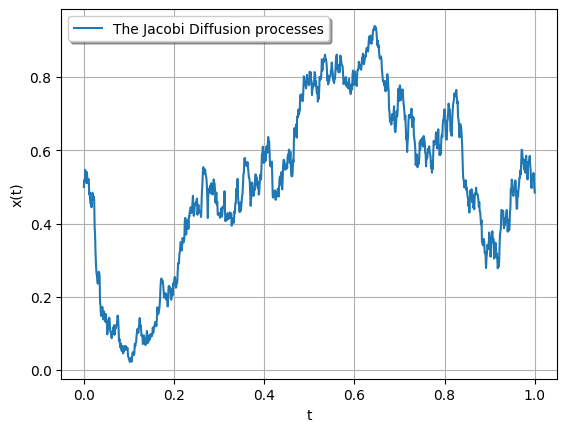

In [36]:
class JacobiDiffusionProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):

        try:
            assert params[0] > 0

            super().__init__(params, T, Nx, Nt, init_state)

            # params = [theta]
            self.bxt = lambda x: self.params[0]  * (.5 - x)
            self.sigmaxt = lambda x: np.sqrt(self.params[0] * x * (1 - x))
        except AssertionError:
            print(f'the input params do not fit the conditions: theta > 0, but {params[0]} where given')

    def sampler_init_state(self):
        return .5 * np.ones(self.Nx)
    
# Parameters
theta = 2

x0 = 0 
Nx = 1
Nt = 1000
T = 1.0 

params = [theta]

JacobiDiffusion = JacobiDiffusionProcess(params, T, Nx, Nt)
t_data, x_data = JacobiDiffusion.EulerSolution()
plt.plot(t_data, x_data, label = 'The Jacobi Diffusion processes')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

# Ann and Gao (inverse of Feller's square root) model

satisfies the following SDE:

$$dX_t = X_t(\theta_1 - (\theta_3^3 - \theta_1\theta_2)X_t)dt + \theta_3X_t^{\frac{3}{2}}dW_t$$

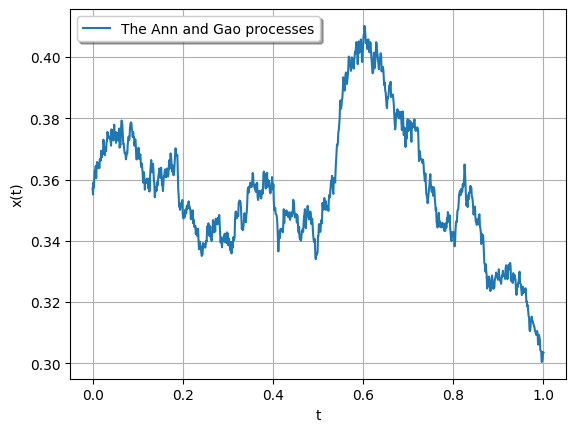

In [42]:
class AnnGaoProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):

        try:

            # assert isinstance(params, List[float])

            super().__init__(params, T, Nx, Nt, init_state)

            # params = [theta1, theta2, theta3]
            theta1, theta2, theta3 = self.params
            self.bxt = lambda x: x * (theta1 - (theta3**3 - theta1 * theta2) * x)
            self.sigmaxt = lambda x: x ** 1.5 * theta3
        except AssertionError:
            print(f'all the input params must of the type float, but {params} where given')

    def sampler_init_state(self):
        return self.params[0] / (self.params[2] - self.params[0] * self.params[1]) * np.ones(self.Nx)
    
# Parameters
theta1 = .1
theta2 = .2
theta3 = .3

x0 = 0 
Nx = 1
Nt = 1000
T = 1.0 

params = [theta1, theta2, theta3]

AnnGao = AnnGaoProcess(params, T, Nx, Nt)
t_data, x_data = AnnGao.EulerSolution()
plt.plot(t_data, x_data, label = 'The Ann and Gao processes')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

# Radial Ornstein-Uhlenbeck process

satisfies the following SDE:

$$dX_t = (\theta X_t^{-1} - X_t)dt + dW_t$$

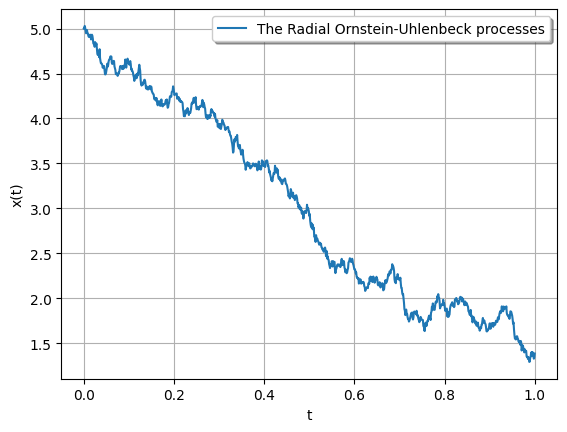

In [46]:
class RadialOUProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):

        try:
            # assert isinstance(params, List[float])

            super().__init__(params, T, Nx, Nt, init_state)

            # params = [theta]
            theta = params[0]
            self.bxt = lambda x: theta / x - x
            self.sigmaxt = lambda x: 1

        except AssertionError:
            print(f'all the input params must of the type float, but {params} where given')

    def sampler_init_state(self):
        return np.ones(self.Nx) / self.params[0]
    
# Parameters
theta = 0.2

x0 = 0 
Nx = 1
Nt = 1000
T = 1.0 

params = [theta]

RadialOU = RadialOUProcess(params, T, Nx, Nt)
t_data, x_data = RadialOU.EulerSolution()
plt.plot(t_data, x_data, label = 'The Radial Ornstein-Uhlenbeck processes')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 6.

Let $$X(t)=e^{-\kappa t} X_0 + \theta (1-e^{-\kappa t}) + \sigma e^{-\kappa t} \int_0^t e^{\kappa s}\sqrt{X(t)}dW(s)$$ be extract solution for CIR model.


 Expand the functionality of the class CoxIngersollRossProcess(StochasticProcess) and compute the first and second moments of the extract solution $\mathbb{E}\{X^n(t)\}$ using the general formula [Jafari, 2017]
$$
\mathbb{E}\{X^n(t)\} = \sum_{j=0}^{[n/2]}A^{n-2j}(t)B^{2j}(t)
\left(\frac{1}{2\kappa}(e^{2\kappa t} - 1)\right)^{2j}, \quad \forall n \in \mathbb{N},
$$
where $A(t)=e^{-\kappa t X_0} + \theta(1-e^{-\kappa t})$,
$B(t)=\sigma e^{-\kappa t}$, $[n/2]$ denotes the greatest integer less than or equal to $\frac{n}{2}$ and $\kappa=1$, $\theta =0.45$, $\sigma=1$.

Jafari M.A. [The Moments for Solution of the Cox-Ingersoll-Ross Interest Rate Model](https://www.sciepub.com/portal/downloads?doi=10.12691/jfe-5-1-4&filename=jfe-5-1-4.pdf) / M.A. Jafari, S. Abbasian // Journal of Finance
and Economics. – 2017. – Vol. 5, № 1. – P. 34—37

Solution:

The CIR process satisfies the following SDE:

$$dX_t = \kappa(\theta - X_t)dt + \sigma\sqrt{X_t}dW_t$$

In [47]:
class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.kappa = params[1]  # mean-reversion rate
        self.theta = params[0]  # long-term mean
        self.sigma = params[2]  # volatility

        # Drift and diffusion terms for CIR process
        self.bxt = lambda x: self.kappa * (self.theta - x)
        self.sigmaxt = lambda x: self.sigma * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return np.full(self.Nx, self.theta)

    # Exact solution for CIR process: X(t)
    def exact_solution(self, t, X0):
        A = np.exp(-self.kappa * t) * X0 + self.theta * (1 - np.exp(-self.kappa * t))
        B = self.sigma * np.exp(-self.kappa * t)
        return A, B

    # Compute moments using Jafari's formula
    def compute_moment(self, t, X0, n):
        A_t, B_t = self.exact_solution(t, X0)
        moment = 0
        
        # Compute the sum in the formula
        for j in range((n // 2) + 1):
            A_term = A_t**(n - 2*j)
            B_term = B_t**(2*j)
            kappa_factor = (1 / (2 * self.kappa)) * (np.exp(2 * self.kappa * t) - 1)
            moment += A_term * B_term * (kappa_factor**(2 * j))
        
        return moment

    # Compute first and second moments
    def first_moment(self, t, X0):
        return self.compute_moment(t, X0, 1)

    def second_moment(self, t, X0):
        return self.compute_moment(t, X0, 2)

# Example usage
params = [0.45, 1, 1]  # [theta, kappa, sigma]
T = 1.0  # Time period
Nx = 1  # Number of paths
Nt = 100  # Time steps
init_state = np.array([0.5])  # Initial state

# Instantiate the CIR process
cir_process = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)

# Compute the first and second moments at time t = 1 for initial state X0 = 0.5
t = 1.0
X0 = 0.5
first_moment = cir_process.first_moment(t, X0)
second_moment = cir_process.second_moment(t, X0)

print(f"First moment at t = {t}: {first_moment}")
print(f"Second moment at t = {t}: {second_moment}")


First moment at t = 1.0: 0.46839397205857214
Second moment at t = 1.0: 1.6004907586026225


Task 7. Suppose we have a standard (zero-mean) Ornstein-Uhlenbeck process defined by
$$
dX_t = -\theta X_t dt + \sigma dW_t, \quad X_0 = x_0,
$$
where $\sigma$ is interpreted as the volatility, and $\theta$ is the speed of reversion.

Define a half-life at time $s$ as the time $h$ such that $𝔼(x_h|x_s)=\frac{1}{2}x_s$. That is, how long until half the deviation from the mean is, in expectation, lost.

This is easy to compute because
\begin{align}
  \frac{1}{2}x_s & =  𝔼(x_h|x_s) \\
                 & = x_s\exp(-\theta h)
\end{align}
and we can cancel the $x_s$ terms to give
\begin{align}
  \frac{1}{2} = \exp(-\theta h)
\end{align}
which rearranges to
\begin{align}
  h = \frac{\ln(2)}{\theta}
\end{align}
The cancellation of $x_s$ means that a half-life does not depend on either $s$ or $x_s$ and so we are entitled to call it "the" half-life of the process.

As one can see, the half-life is a constant for an Ornstein-Uhlenbeck process.

